In [12]:
import torch
import transformers

from tqdm import tqdm
import numpy as np
torch.cuda.memory_allocated()

7650957312

In [2]:
# from huggingface_hub import login

# # hf_token_path = "hf.txt"

# # with open(hf_token_path) as f:
# #     hf_token = f.read()
# #     f.close()

# # login(token=hf_token)
# login()

In [3]:
import os

def load_txt_files_to_dict(directory, filetype=".txt"):
    text_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(filetype):
            file_path = os.path.join(directory, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                text_dict[os.path.splitext(filename)[0]] = text.split("\n")
    return text_dict

def load_txt_files_to_dict__flores(directory):
    text_dict = {}
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
            # Flores' files with text do not have the extension. The language is indicated after the dot symbol
            text_dict[os.path.splitext(filename)[1][1:]] = text.split("\n")
    return text_dict

In [4]:
#!unzip train.csv.zip

In [5]:
import pandas as pd

'''
data_dir = "Grammar Correction.csv"
df = pd.read_csv(data_dir)
dataset_texts = {'ungrammatical':df['Ungrammatical Statement'].to_list(), 
                 'standard':df['Standard English'].to_list()}
'''
data_dir = "train.csv"
df = pd.read_csv(data_dir)
df['text'] = df['Prompt']+'\n'+df['Answer']
dataset_texts = {'hallucination':df[df['Target']==1]['text'].astype(str).to_list(), 
                 'standard':df[df['Target']==0]['text'].astype(str).to_list()}
dataset_texts['standard'] = dataset_texts['standard'][:len(dataset_texts['hallucination'])]
del df

In [6]:
print(dataset_texts.keys())
[(k, len(v)) for k, v in dataset_texts.items()]

dict_keys(['hallucination', 'standard'])


[('hallucination', 894), ('standard', 894)]

In [7]:
from transformers.trainer_pt_utils import LengthGroupedSampler
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def data_collator(examples, padding_value=0, max_length=2048):
    def trim_and_pad(seq, batch_first, padding_value):
        return pad_sequence([s[:max_length] for s in seq], batch_first=True, padding_value=padding_value)

    padding_value = tokenizer.pad_token_id or padding_value

    input_ids = trim_and_pad(
        [torch.tensor(example["input_ids"], dtype=torch.int32) for example in examples],
        batch_first=True,
        padding_value=padding_value,
    )
    corpus_ids = torch.stack([torch.tensor(example["corpus_id"], dtype=torch.int32) for example in examples])

    return dict(input_ids=input_ids, corpus_ids=corpus_ids, attention_mask=input_ids.ne(padding_value))

In [8]:
def get_first_level_layer_names(model):
    first_level_layers = ["embed_tokens"]
    for name, module in model.named_modules():
        if name.count(".") == 2:
            first_level_layers.append(name.split(".", 1)[1])
    return first_level_layers

In [9]:
def wrap_outputs_to_dict(outputs, batch, layer_names):
    # Length of non-pad elems to not save embeddings for padding tokens
    batch_lengths = batch["attention_mask"].sum(1)

    listed_hidden_states = []
    outputs.hidden_states = outputs.hidden_states
    for hidden_state_tensor in outputs.hidden_states:
        listed_hidden_state_tensor = {
            batch["corpus_ids"][i]: hidden_state_tensor[i, : batch_lengths[i]] for i in range(len(hidden_state_tensor))
        }
        listed_hidden_states.append(listed_hidden_state_tensor)
    hidden_state_tensors = {}
    for i, hidden_state in enumerate(listed_hidden_states):
        for idx, tensor in hidden_state.items():
            hidden_state_tensors["-".join([str(idx.numpy()), layer_names[i]])] = tensor.detach().cpu()
    return hidden_state_tensors

In [10]:
from safetensors import safe_open
from safetensors.torch import save_file
import gc


def process_and_save_embeddings(model, model_id, dataloader, current_lang):
    model_dir = model_id.split("/")[1]
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    filename = f"{model_dir}/{current_lang}.st"
    if f"{current_lang}.st" in os.listdir(model_dir):
        print(current_lang, 'done')
        return None
        
    torch.cuda.empty_cache()
    layer_names = get_first_level_layer_names(model)
    keys = ["attention_mask", "corpus_ids"]

    hidden_state_tensors = {}
    for batch in tqdm(dataloader, leave=True):
        info_data = {k: batch[k] for k in keys}

        input_ids = batch["input_ids"].to(device=device)
        attention_mask = batch["attention_mask"].to(device=device)

        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # in place 'or' operation
        hidden_state_tensors |= wrap_outputs_to_dict(output, info_data, layer_names)


    # This is going to be num_layers * batch_size
    print(current_lang, len(hidden_state_tensors))

    filename = f"{model_dir}/{current_lang}.st"
    save_file(hidden_state_tensors, filename)

    for _ in range(2):
        torch.cuda.empty_cache()
        gc.collect()

    return hidden_state_tensors

In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda:0"
model_names = [
    # "ai-forever/mGPT",
    # "gradientai/Llama-3-8B-Instruct-Gradient-1048k",
    # "mistralai/Mistral-7B-Instruct-v0.3",
    # Proj 34
    # "Qwen/Qwen2-0.5B-Instruct"
    "microsoft/Phi-3.5-mini-instruct"
]

for model_id in model_names:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    # tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()}
    tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()}

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        # attn_implementation="flash_attention_2", # not for V100
        use_cache=False,
        torch_dtype=torch.bfloat16,
        device_map=device,
    )

    model_dir = model_id.split("/")[1]
    batch_size = 16

    for current_lang in (tokenized_texts.keys()):
        filename = f"{model_dir}/{current_lang}.st"

        # if os.path.exists(filename):
        #     continue

        current_dataset = [
            {"input_ids": input_ids, "corpus_id": i}
            for i, input_ids in enumerate(tokenized_texts[current_lang]["input_ids"])
        ]

        current_sampler = LengthGroupedSampler(
            dataset=current_dataset,
            batch_size=batch_size,
        )

        current_loader = DataLoader(
            current_dataset,
            collate_fn=data_collator,
            sampler=current_sampler,
            batch_size=batch_size,
            shuffle=False,
        )

        hidden_state_tensors = process_and_save_embeddings(model, model_id, current_loader, current_lang)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

hallucination done


100%|█████████████████████████████████████████████████████████████████████████████| 56/56 [04:42<00:00,  5.04s/it]


standard 29502


In [13]:
tokenized_texts.keys()

dict_keys(['hallucination', 'standard'])

In [14]:
import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

7650957312


# Play part

In [15]:
for i, (name, module) in enumerate(model.named_modules()):
    print(name)
    if i > 20:
        break


model
model.embed_tokens
model.embed_dropout
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.o_proj
model.layers.0.self_attn.qkv_proj
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.gate_up_proj
model.layers.0.mlp.down_proj
model.layers.0.mlp.activation_fn
model.layers.0.input_layernorm
model.layers.0.resid_attn_dropout
model.layers.0.resid_mlp_dropout
model.layers.0.post_attention_layernorm
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.o_proj
model.layers.1.self_attn.qkv_proj


In [16]:
names = get_first_level_layer_names(model)

In [17]:
names, len(names)

(['embed_tokens',
  'layers.0',
  'layers.1',
  'layers.2',
  'layers.3',
  'layers.4',
  'layers.5',
  'layers.6',
  'layers.7',
  'layers.8',
  'layers.9',
  'layers.10',
  'layers.11',
  'layers.12',
  'layers.13',
  'layers.14',
  'layers.15',
  'layers.16',
  'layers.17',
  'layers.18',
  'layers.19',
  'layers.20',
  'layers.21',
  'layers.22',
  'layers.23',
  'layers.24',
  'layers.25',
  'layers.26',
  'layers.27',
  'layers.28',
  'layers.29',
  'layers.30',
  'layers.31'],
 33)

In [18]:
# Number of batches
len(current_loader)

56

# Calculating Metrics

In [19]:
import torch
import transformers

from tqdm import tqdm
import numpy as np
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [20]:
import os

def load_txt_files_to_dict(directory):
    text_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                text_dict[os.path.splitext(filename)[0]] = text.split("\n")
    return text_dict

In [21]:
[(k, len(v)) for k, v in dataset_texts.items()]

[('hallucination', 894), ('standard', 894)]

In [22]:
def unfold_dict(d, keep_ids=None):
    hierarchical = {}
    keep_ids = set(keep_ids) if keep_ids is not None else set()
    for key, value in tqdm(d.items()):
        sentence_id, layer = key.split("-")
        if layer not in hierarchical:
            hierarchical[layer] = {}
        if int(sentence_id) in keep_ids:
            hierarchical[layer][sentence_id + "_full"] = value
        hierarchical[layer][sentence_id] = value#.mean(0, keepdims=True)
    return hierarchical

In [23]:
dataset_texts.keys()

dict_keys(['hallucination', 'standard'])

In [24]:
from tqdm.auto import tqdm
from safetensors import safe_open
from safetensors.torch import save_file

hidden_states = {}

for language in dataset_texts.keys():
    filename = f"{model_dir}/{language}.st"
    hidden_states[language] = {}
    with safe_open(filename, framework="pt", device="cpu") as f:
        for key in f.keys():
            hidden_states[language][key] = f.get_tensor(key)
        hidden_states[language] = unfold_dict(hidden_states[language])

  0%|          | 0/29502 [00:00<?, ?it/s]

  0%|          | 0/29502 [00:00<?, ?it/s]

In [25]:
len(sorted(list(hidden_states.keys()))), \
sorted(list(hidden_states.keys())), 

(2, ['hallucination', 'standard'])

In [25]:
max_sent_length = -1
for lang in hidden_states.keys():
    max_sent_length = max(max_sent_length, 
                    max([hidden_states[lang]["embed_tokens"][key].shape[0] \
                         for key in hidden_states[lang]["embed_tokens"].keys()]))
print(max_sent_length)

1122


In [26]:
import llm_microscope
import skdim

import numpy as np
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

### Intrinsic dimensionality with aggregation

In [27]:
from collections import defaultdict
id_estimates = defaultdict(lambda: defaultdict(dict))


idx = [k for k in hidden_states['standard']["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        # sentence_emb = torch.cat([sentences[i] for i in idx])
        # for Qwen2-0.5 notebook only
        sentence_emb = torch.stack([sentences[i].mean(dim=0) for i in sentences.keys()
                                    if len(sentences[i])!=0])
        id_estimator = skdim.id.TwoNN(discard_fraction=0.1)
        id_estimate = id_estimator.fit_transform(sentence_emb.to(dtype=float).numpy().astype(float))
        #id_estimate = llm_microscope.intrinsic_dimension(sentence_emb, reduction_factor=4, device="cuda:2")
        id_estimates[language][layer] = id_estimate

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [28]:
list_layers = set(hidden_states['standard'].keys())
list_layers.remove("embed_tokens")
list_layers = list(list_layers)
list_layers.sort(key=lambda x: int(x.split(".")[1]))
list_layers = ["embed_tokens"] + list_layers
list_layers

['embed_tokens',
 'layers.0',
 'layers.1',
 'layers.2',
 'layers.3',
 'layers.4',
 'layers.5',
 'layers.6',
 'layers.7',
 'layers.8',
 'layers.9',
 'layers.10',
 'layers.11',
 'layers.12',
 'layers.13',
 'layers.14',
 'layers.15',
 'layers.16',
 'layers.17',
 'layers.18',
 'layers.19',
 'layers.20',
 'layers.21',
 'layers.22',
 'layers.23',
 'layers.24',
 'layers.25',
 'layers.26',
 'layers.27',
 'layers.28',
 'layers.29',
 'layers.30',
 'layers.31']

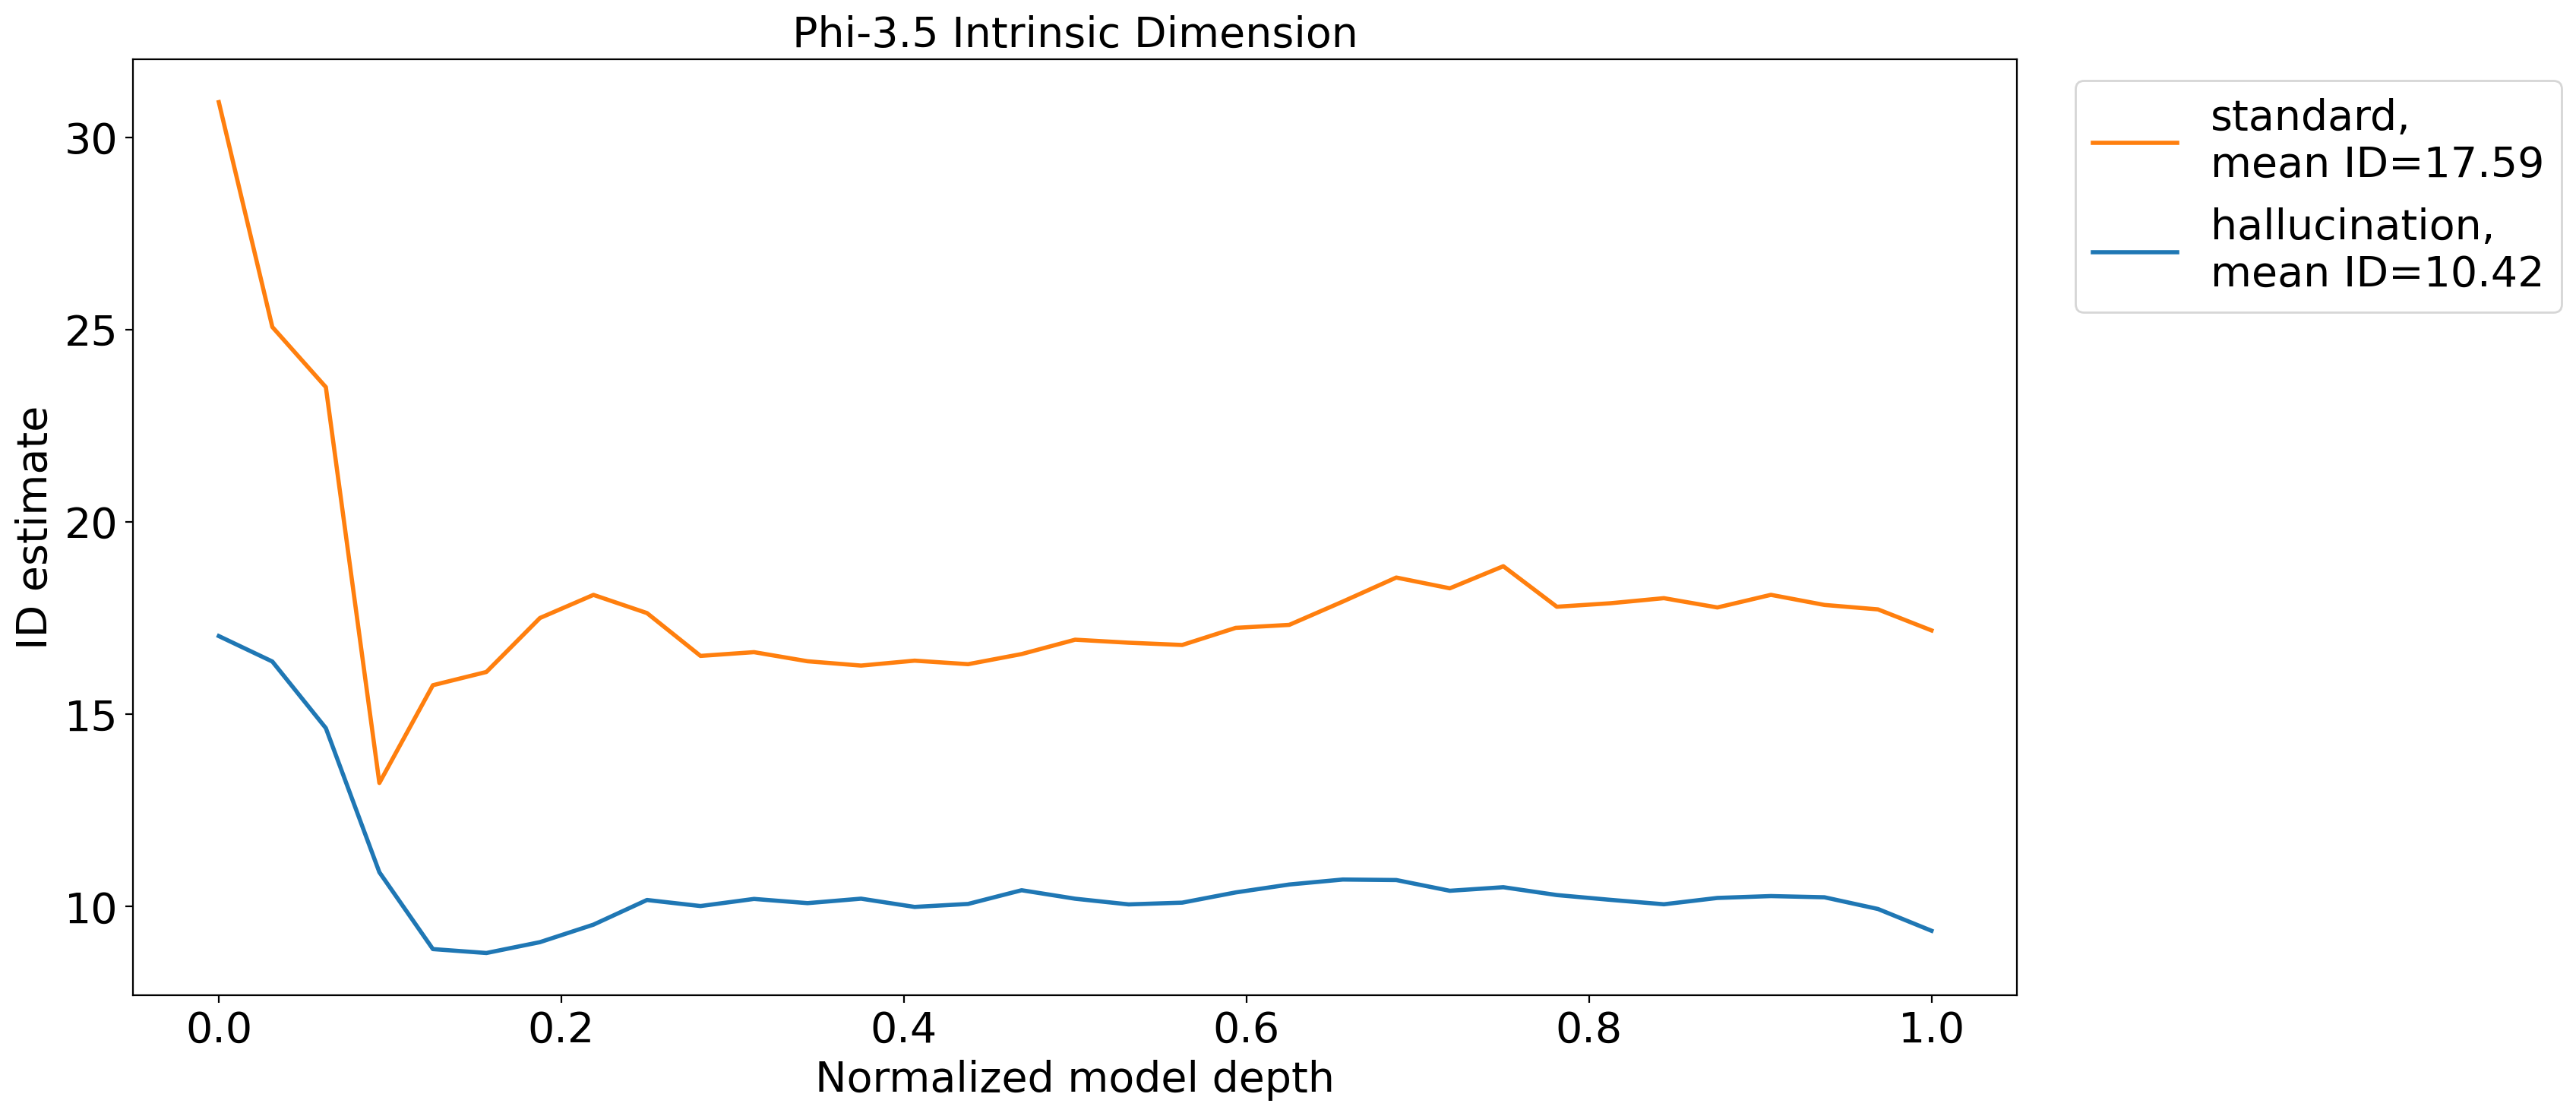

In [29]:
plt.figure(figsize=(16,8))
title = model_dir.rsplit("-", 2)[0]
lw=2
fs=20
plt.title(f"{title} Intrinsic Dimension", fontsize=fs)

mean_metric_list = []

for language, estimate in id_estimates.items():
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer])
    mean_metric = np.mean(estimates[1:])
    mean_metric_list.append(mean_metric)
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, linewidth=lw,
             label=f"{language},\nmean ID={mean_metric:.2f}")
plt.xlabel("Normalized model depth", fontsize=fs)
plt.ylabel("ID estimate", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], fontsize=fs,
           loc='upper center', bbox_to_anchor=(1.16, 1))
plt.savefig("results/id_hallucination.png", format='png', dpi=600, bbox_inches='tight')
plt.show()

### Anisotropy

In [48]:
from collections import defaultdict
import torch
from scipy.sparse.linalg import svds
anisotropy_estimates = defaultdict(lambda: defaultdict(dict))

def calculate_anisotropy_torch(emb):
    embeddings = emb - emb.mean(dim=0, keepdim=True)
    # embeddings = emb 
    num_iters = 70   
    x = torch.randn(embeddings.shape[0], device=embeddings.device, dtype=emb.dtype)
    for i in range(num_iters):  # критерий останова        
        x /= torch.norm(x)
        x = x @ embeddings
        x /= torch.norm(x)
        x = embeddings @ x   
    sigma = torch.norm(x)
    anisotropy = sigma ** 2 / torch.norm(embeddings) ** 2    
    return anisotropy

idx = [k for k in hidden_states['standard']["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):            
        max_lang_sent_len = max([hidden_states[language]["embed_tokens"][key].shape[0] \
                         for key in hidden_states[language]["embed_tokens"].keys()])
        #sentence_emb = torch.stack([torch.nn.functional.pad(sentences[i], (0, 0, 0, max_lang_sent_len-sentences[i].shape[0]),  
        #                                 value=0.0) for i in idx if len(sentences[i])!=0])
        #anisotropy_estimate = sum([calculate_anisotropy_torch(sentence_emb[j]) \
        #                           for j in range(sentence_emb.shape[0])]) / sentence_emb.shape[0]
        sentence_emb = torch.stack([sentences[i].mean(dim=0) for i in idx if len(sentences[i])!=0])
        anisotropy_estimate = calculate_anisotropy_torch(sentence_emb)
        # anisotropy_estimate = llm_microscope.calculate_anisotropy_torch(sentence_emb)
        anisotropy_estimates[language][layer] = anisotropy_estimate.to('cpu')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

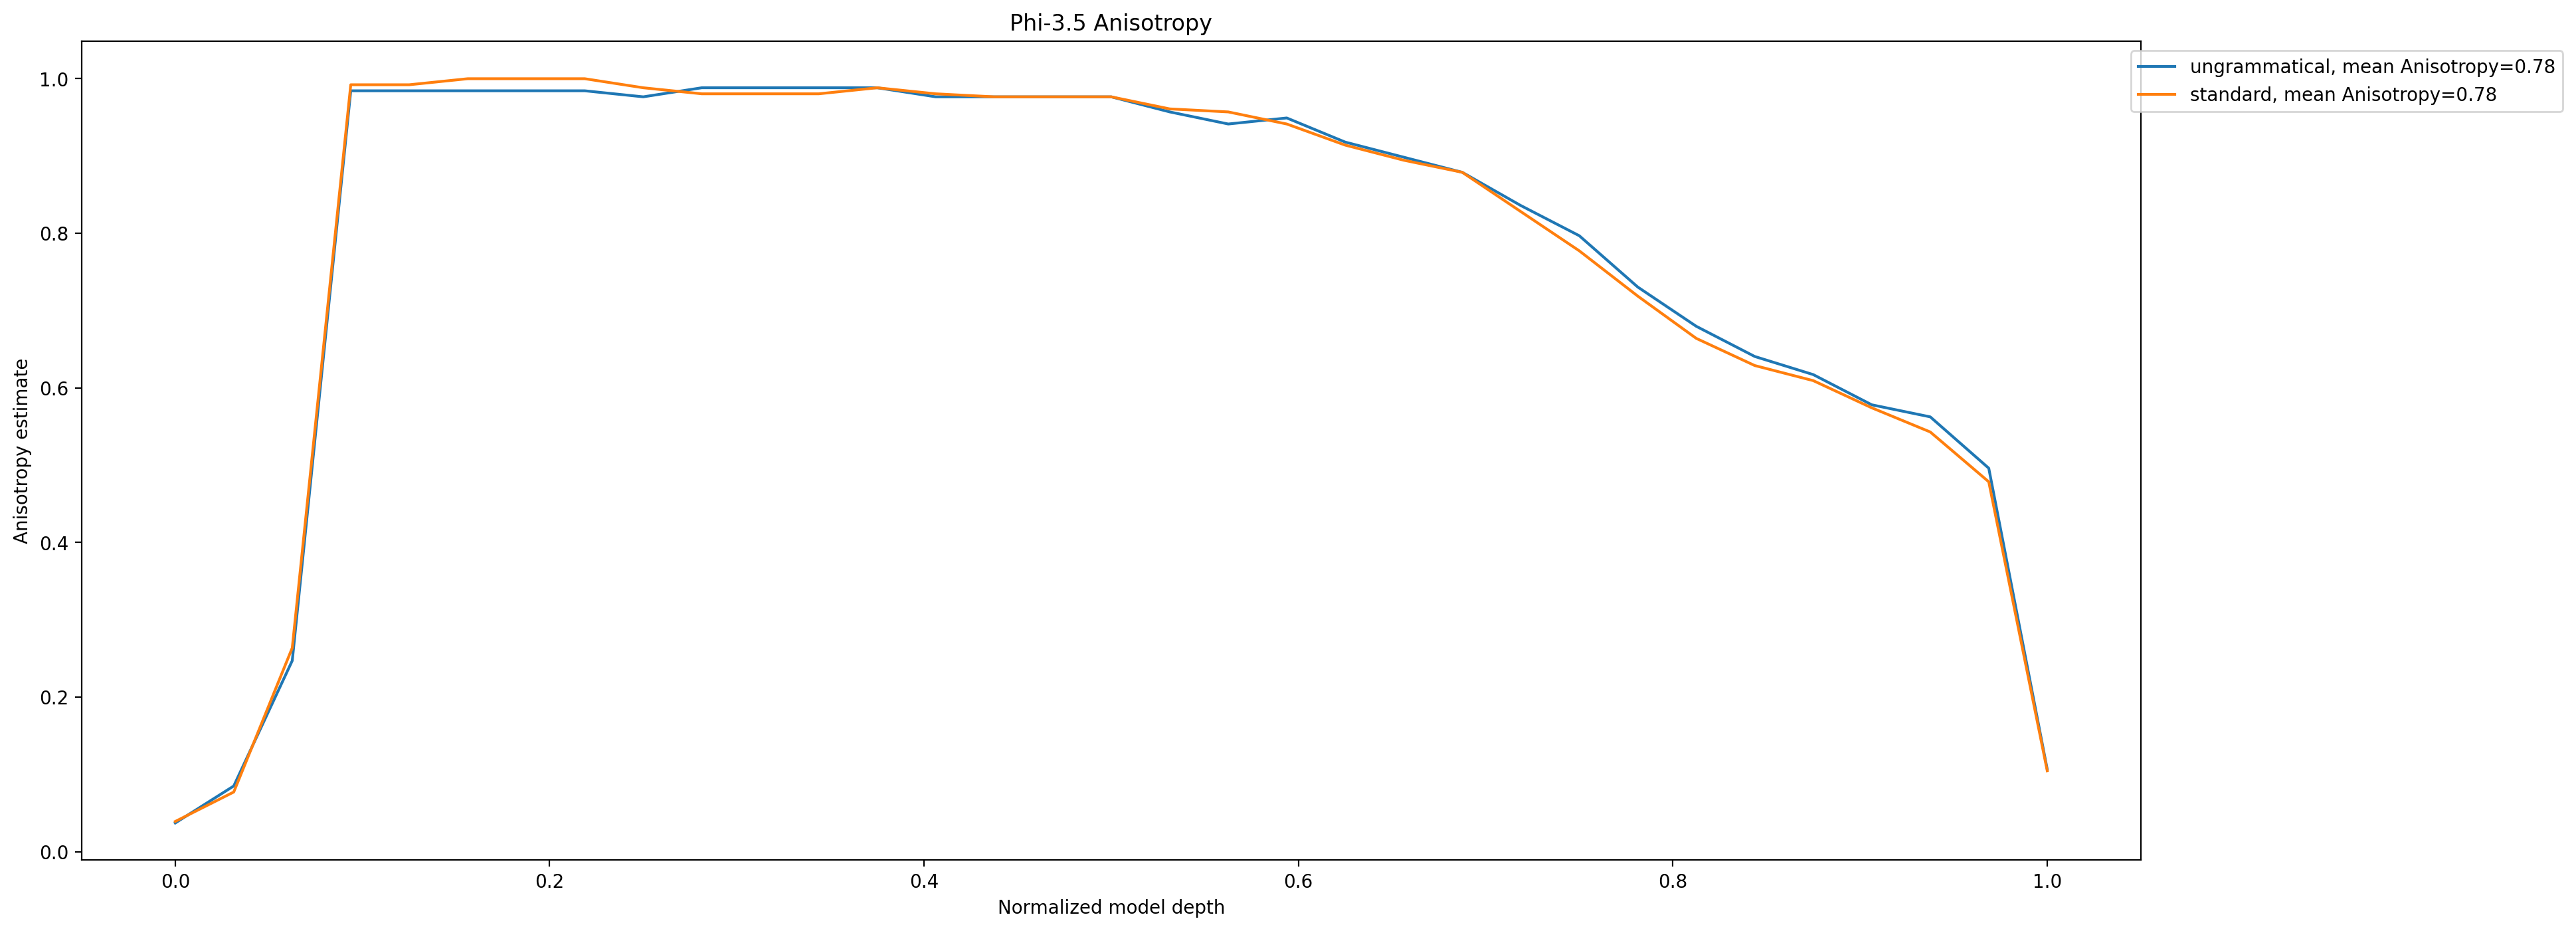

In [50]:
plt.figure(figsize=(20,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Anisotropy")

mean_metric_list = []

for language, estimate in anisotropy_estimates.items():
    estimates = []
    for layer in list_layers:
        estimates.append(float(estimate[layer]))

    mean_metric = np.mean(estimates)
    mean_metric_list.append(mean_metric)
    
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean Anisotropy={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth")
plt.ylabel("Anisotropy estimate")

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())
plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', bbox_to_anchor=(1.1, 1))

plt.savefig("results/anisotropy_no_agg_ungrammatical.png", format='png', dpi=600, bbox_inches='tight')

plt.show()

### KL divergence with aggregation

In [51]:
from collections import defaultdict
import torch
import torch.nn.functional as F
kl_agg_estimates = defaultdict(lambda: defaultdict(dict))
sentence_eng_emb = defaultdict()

idx = [k for k in hidden_states['standard']["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    if language=='standard':
        for layer, sentences in tqdm(hidden_state.items(), leave=False):
            sentence_eng_emb[layer] = torch.stack([sentences[i].mean(dim=0) for i in idx if len(sentences[i])!=0])
for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        sentence_emb = torch.stack([sentences[i].mean(dim=0) for i in idx if len(sentences[i])!=0])
        kl_estimate = F.kl_div(F.log_softmax(sentence_eng_emb[layer], dim=1), F.softmax(sentence_emb, dim=1))
        kl_agg_estimates[language][layer] = kl_estimate.to('cpu')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

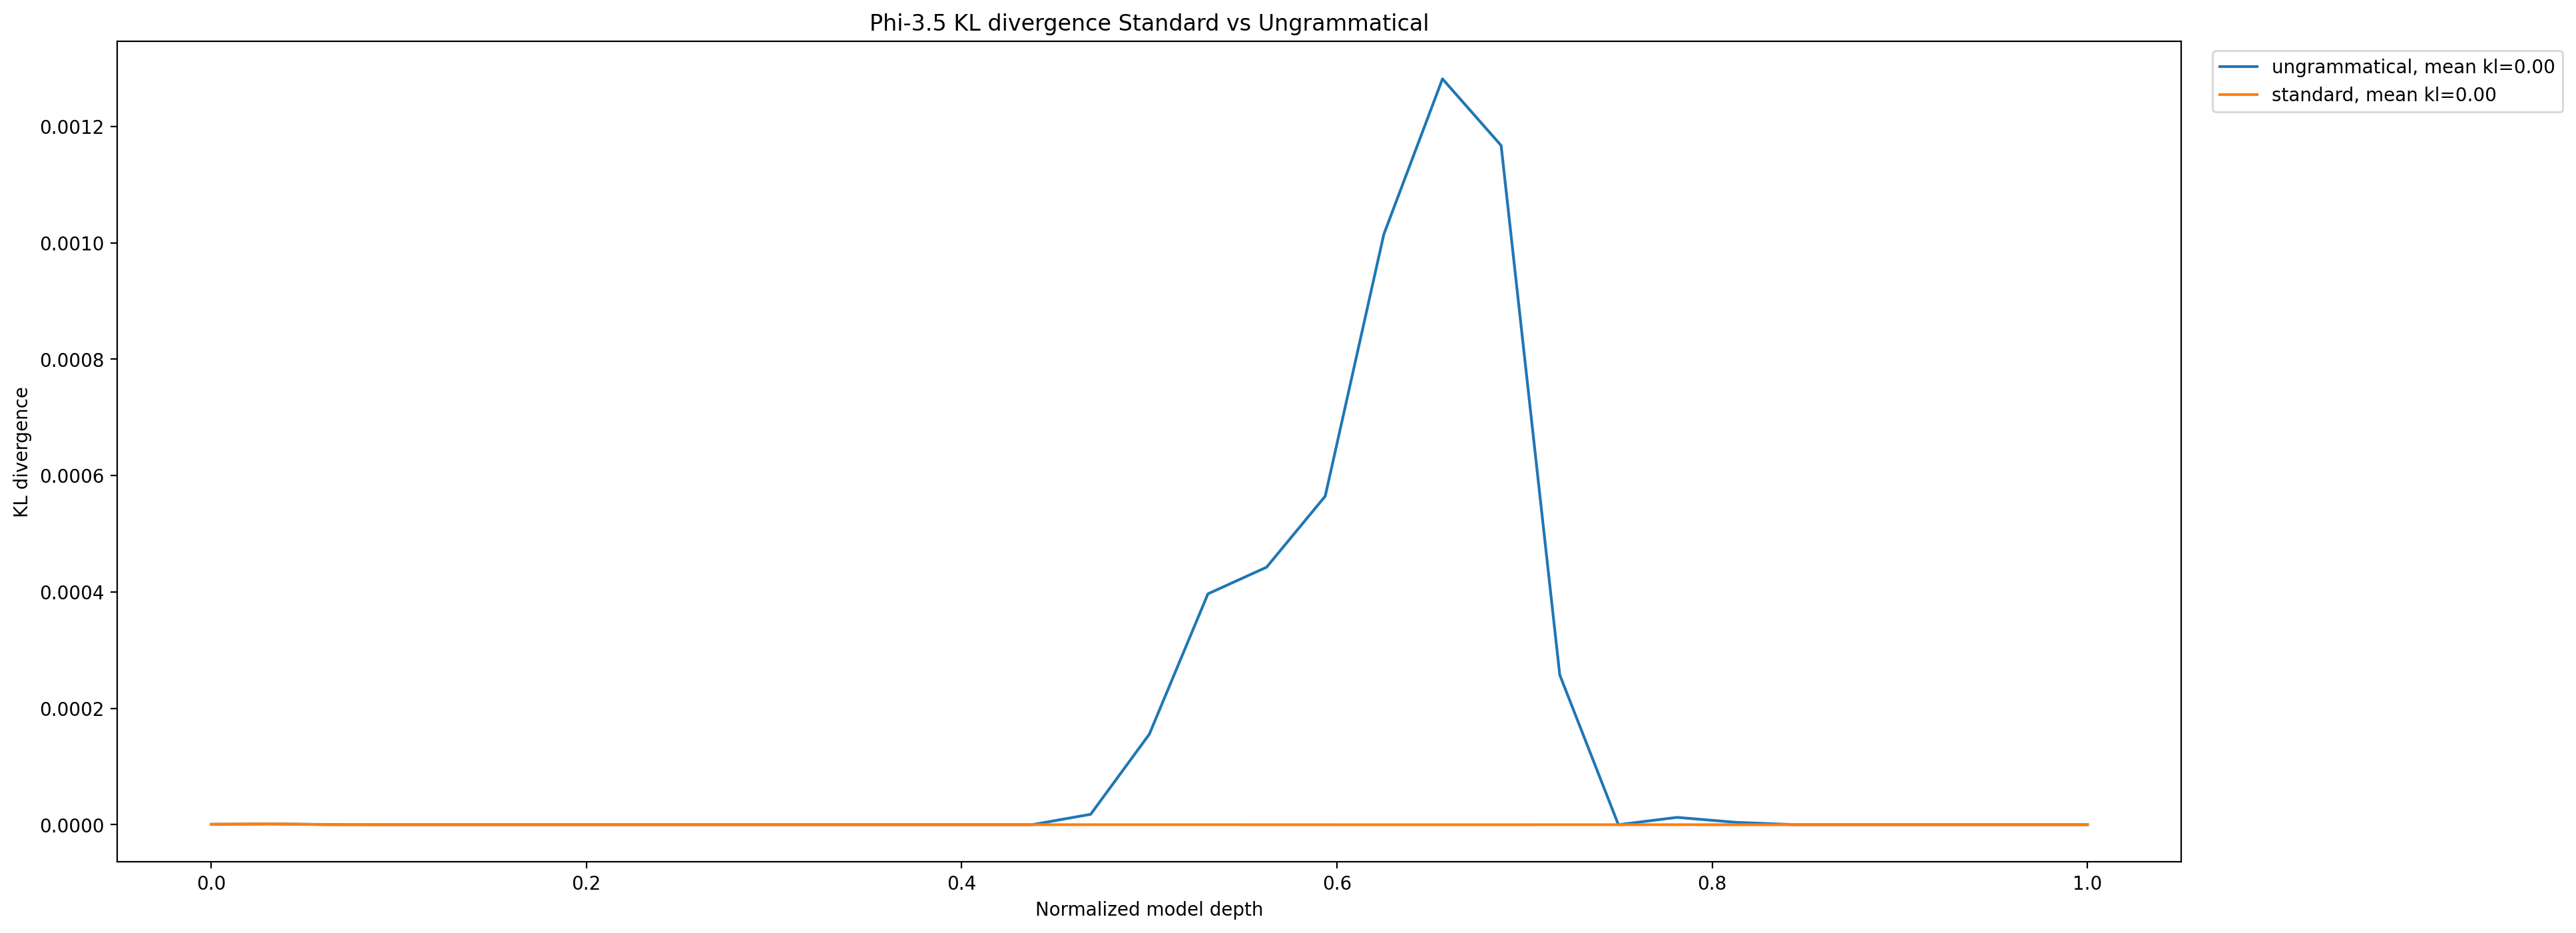

In [53]:
plt.figure(figsize=(20,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} KL divergence Standard vs Ungrammatical")

mean_metric_list = []

list_layers = kl_agg_estimates[language].keys()

for language, estimate in kl_agg_estimates.items():
    estimates = []
    for layer in list_layers:
        estimates.append(float(estimate[layer]))
    mean_metric = np.mean(estimates)
    mean_metric_list.append(mean_metric)
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean kl={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth")
plt.ylabel("KL divergence")

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', bbox_to_anchor=(1.1, 1))
plt.savefig("results/kl_agg_standard_other_ungramm.png", format='png', dpi=600, bbox_inches='tight')
plt.show()

### Correlation of English and other languages

In [114]:
from collections import defaultdict
cosine_sims = defaultdict(lambda: defaultdict(dict))


idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    if language == language_en:
        continue
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        if len(sentences) != 998:
            print(f"Dropping '{language}' lang, len={len(sentences)}")
            break
            
        sentence_emb = torch.cat([sentences[i] for i in idx]).to(dtype=torch.float32, device="cuda:0")[:-1]
        english_sentence_emb = torch.cat([hidden_states[language_en][layer][i] for i in idx]).to(dtype=torch.float32, device="cuda:0")[:-1]
        # cosine_sim = llm_microscope.procrustes_similarity(sentence_emb, english_sentence_emb)
        cosine_sim = llm_microscope.procrustes_similarity_centered(sentence_emb, english_sentence_emb)
        cosine_sims[language][layer][median_sentence_id] = cosine_sim

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

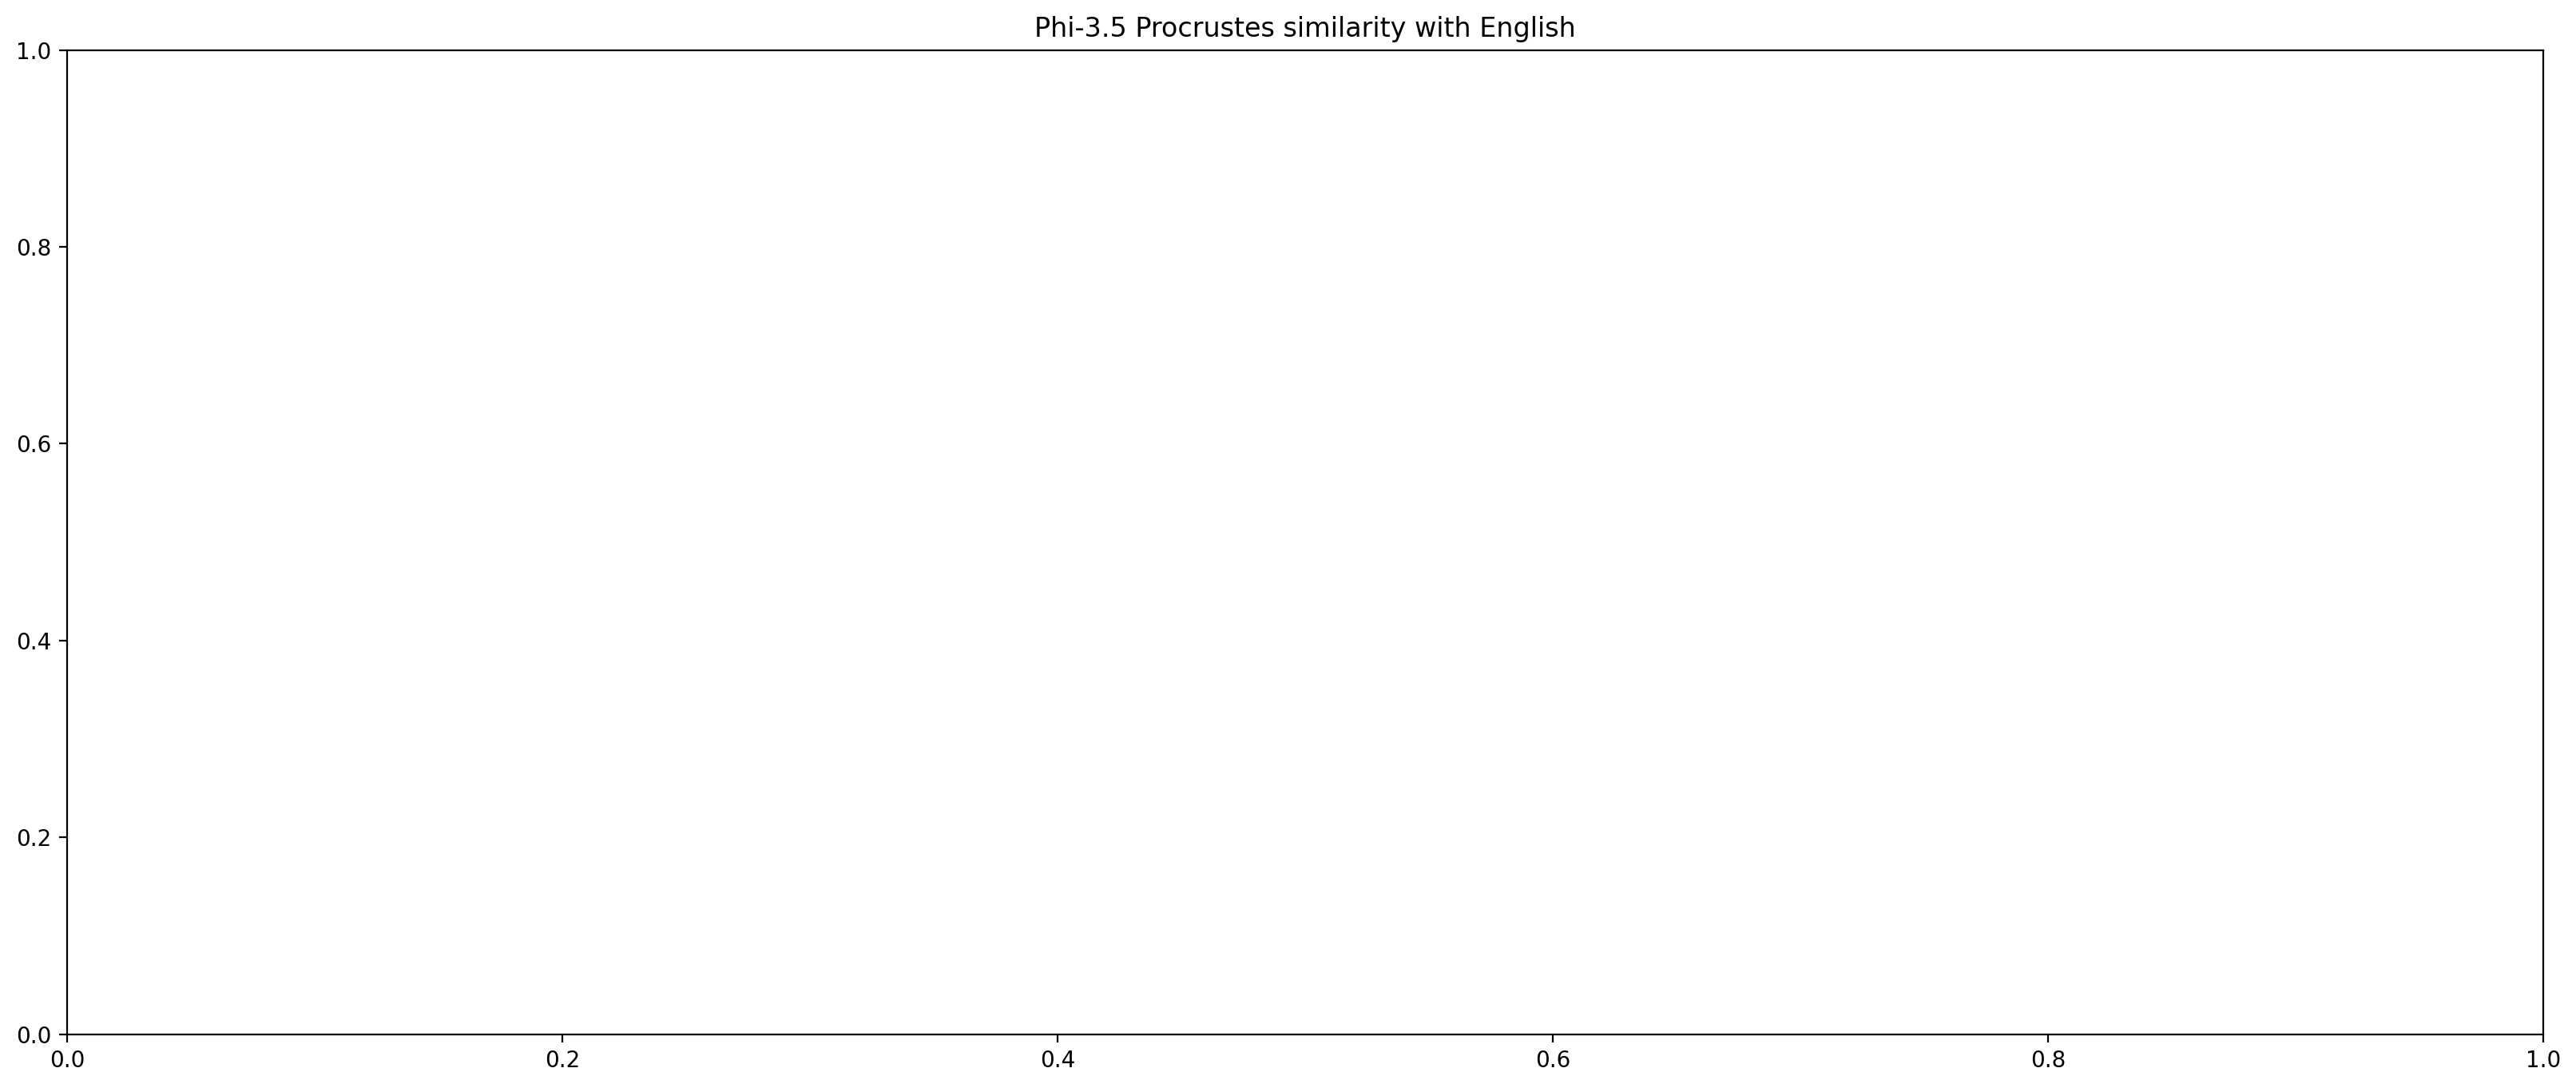

In [115]:
plt.figure(figsize=(20,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Procrustes similarity with English")

mean_metric_list = []

for language, estimate in cosine_sims.items():
    if language == "en":
        continue
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer][median_sentence_id])
        
    mean_metric = np.mean(estimates[1:])
    mean_metric_list.append(mean_metric)
    
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean similarity={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth")
plt.ylabel("Procrustes similarity")

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', bbox_to_anchor=(1.1, 1))

plt.show()

# Play - interp

In [57]:
names, len(names)

(['embed_tokens',
  'layers.0',
  'layers.1',
  'layers.2',
  'layers.3',
  'layers.4',
  'layers.5',
  'layers.6',
  'layers.7',
  'layers.8',
  'layers.9',
  'layers.10',
  'layers.11',
  'layers.12',
  'layers.13',
  'layers.14',
  'layers.15',
  'layers.16',
  'layers.17',
  'layers.18',
  'layers.19',
  'layers.20',
  'layers.21',
  'layers.22',
  'layers.23',
  'layers.24',
  'layers.25',
  'layers.26',
  'layers.27',
  'layers.28',
  'layers.29',
  'layers.30',
  'layers.31'],
 33)

In [118]:
hidden_states.keys()

dict_keys(['ukr_Cyrl', 'rus_Cyrl', 'spa_Latn', 'eng_Latn', 'ita_Latn', 'nld_Latn', 'fra_Latn', 'deu_Latn', 'arb_Arab'])

In [123]:
len(hidden_states['arb_Arab']['layers.0'].keys() ), (hidden_states['arb_Arab']['layers.0'].keys() )

(998,
 dict_keys(['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', 

In [142]:
(hidden_states['arb_Arab']['layers.1']['4'])

tensor([[-0.0171, -0.0403,  0.0342,  ...,  0.0317, -0.0203, -0.0571]])